<a href="https://colab.research.google.com/github/christophercallaghan2022/MSDS422/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 

Use all explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study. Use one of two response variables: (1) the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars. Employ at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, ridge regression, lasso regression, and elastic net. Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. Python scikit-learn should be your primary environment for conducting this research. Note that it is not necessary to employ polynomial regression in this assignment.

Regarding the management problem, imagine that you are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. Of the modeling methods examined in your study, which would you recommend to management, and why?

#Data Dictionary




* Neighborhood = Name of the Boston neighborhood
* mv = Median valeu homes in thousands of 1970 dollars
* nox = Air pollution
* crim = crime rate
* zn = Percent of land zoned for lots
* indus = Percent of business that is industrial or nonretail
* chas = On the Charles River (1) or not (0)
* rooms = Average number of rooms per home
* age = Percentage of homes built before 1940
* dis = Weighted distance to employment centers
* rad = Accessibility to radial highways
* tax = Tax rate
* ptratio = Pupil/teacher ratio in public schools
* lstat = percentage of population of lower socio-economic status



# Data Preparation

In [ ]:
#S2 Mount Google Drive to Colab Enviorment
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
#S3 Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/MSDS_422/Assignment_2
!pwd
!ls
print('Working Directory')
print(os.getcwd())

/content/gdrive/My Drive/MSDS_422/Assignment_2
/content/gdrive/My Drive/MSDS_422/Assignment_2
boston.csv  plot-corr-map.pdf
Working Directory
/content/gdrive/My Drive/MSDS_422/Assignment_2


In [2]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from math import sqrt  # for root mean-squared error calculation

# read data for the Boston Housing Study
# creating data frame restdata
boston_input = pd.read_csv('boston.csv')

# check the pandas DataFrame object boston_input
print('\nboston DataFrame (first and last five rows):')
print(boston_input.head())
print(boston_input.tail())

print('\nGeneral description of the boston_input DataFrame:')
print(boston_input.info())

# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)
print('\nGeneral description of the boston DataFrame:')
print(boston.info())

print('\nDescriptive statistics of the boston DataFrame:')
print(boston.describe())


boston DataFrame (first and last five rows):
  neighborhood     crim    zn  indus  chas  ...  rad  tax  ptratio  lstat    mv
0       Nahant  0.00632  18.0   2.31     0  ...    1  296     15.3   4.98  24.0
1   Swampscott  0.02731   0.0   7.07     0  ...    2  242     17.8   9.14  21.6
2   Swanpscott  0.02729   0.0   7.07     0  ...    2  242     17.8   4.03  34.7
3   Marblehead  0.03237   0.0   2.18     0  ...    3  222     18.7   2.94  33.4
4   Marblehead  0.06905   0.0   2.18     0  ...    3  222     18.7   5.33  36.2

[5 rows x 14 columns]
    neighborhood     crim   zn  indus  chas  ...  rad  tax  ptratio  lstat    mv
501     Winthrop  0.06263  0.0  11.93     0  ...    1  273     21.0   9.67  22.4
502     Winthrop  0.04527  0.0  11.93     0  ...    1  273     21.0   9.08  20.6
503     Winthrop  0.06076  0.0  11.93     0  ...    1  273     21.0   5.64  23.9
504     Winthrop  0.10959  0.0  11.93     0  ...    1  273     21.0   6.48  22.0
505     Winthrop  0.04741  0.0  11.93     0  .

# Data Exploration and Visualization

Based on the request, we know that the target variable for this model will be the median value of owner-occupied homes.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

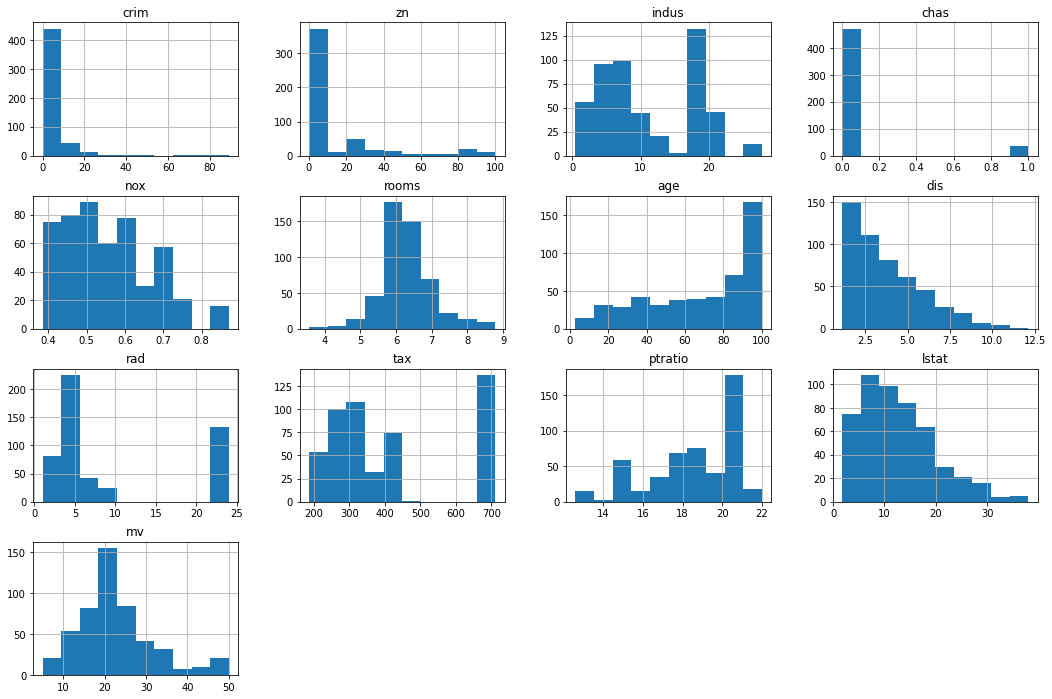

In [4]:
# Check distributions of non-categorical variables for boston housing by histogram
boston.hist(figsize=(18,12))
plt.show('plot-histogram-boston')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


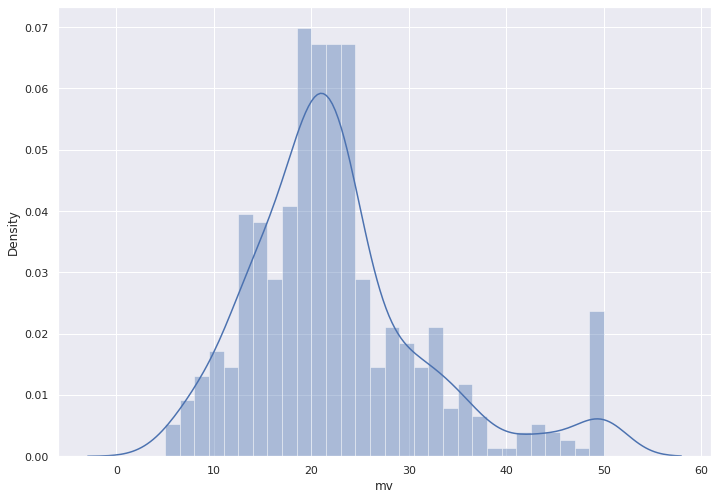

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(boston['mv'], bins=30)
plt.show()

It can be seen that the values appear to have a near normal distribution.  There is an outlier on the right tail.  We can attribute this outlier to the cap that was put on for any home exceeding $50,000

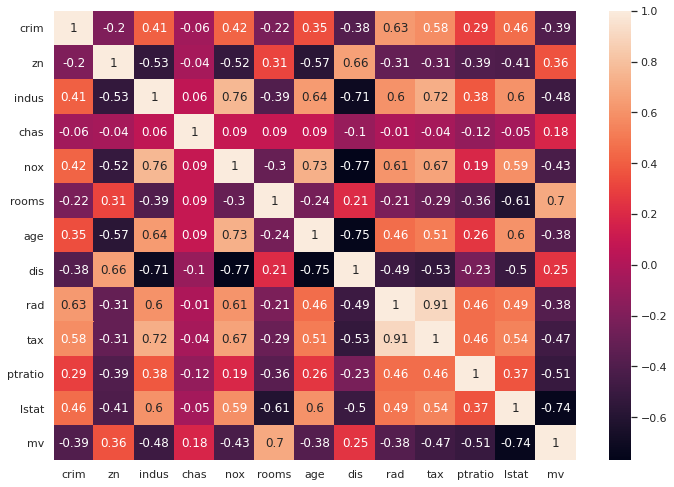

In [6]:
correlation_matrix = boston.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

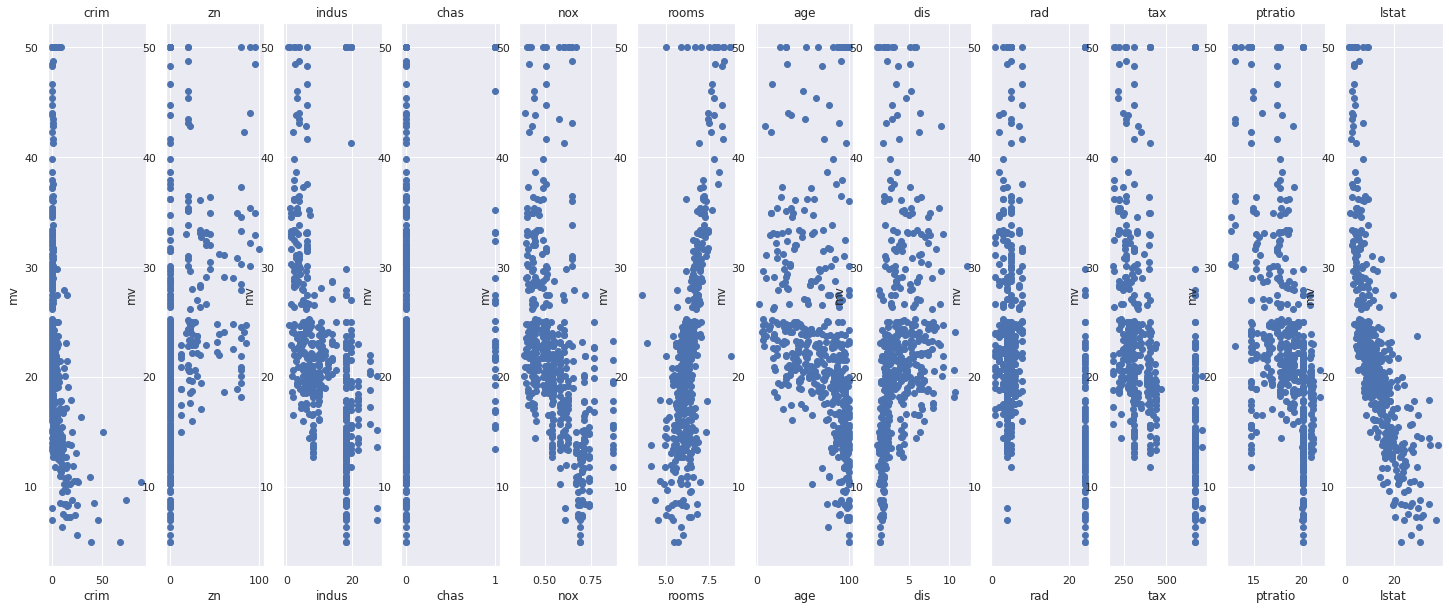

In [7]:
plt.figure(figsize=(25, 10))

features = ['crim', 'zn','indus','chas','nox','rooms','age','dis','rad','tax','ptratio','lstat']
target = boston['mv']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('mv')

##Initial Observations

Since we set our target variable to 'mv' we are primarily concerned with the bottom row of the correlation matrix

*   It can be seend that the number of rooms has the strongest positive correlation at 0.7
*   Conversly, the percentage of lower status of the population has teh strongest negative correlation at -0.74
*   The skewed distribution of median house values (and several features) suggests that a log transformation would be appropriate.



# Data Scaling

In [9]:
# set up preliminary data for data for fitting the models 
# the first column is the median housing value response
# the remaining columns are the explanatory variables
prelim_model_data = np.array([boston.mv,\
    boston.crim,\
    boston.zn,\
    boston.indus,\
    boston.chas,\
    boston.nox,\
    boston.rooms,\
    boston.age,\
    boston.dis,\
    boston.rad,\
    boston.tax,\
    boston.ptratio,\
    boston.lstat]).T

# dimensions of the polynomial model X input and y response
# preliminary data before standardization
print('\nData dimensions:', prelim_model_data.shape)

# standard scores for the columns... along axis 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(prelim_model_data))
# show standardization constants being employed
print(scaler.mean_)
print(scaler.scale_)

# the model data will be standardized form of preliminary model data
model_data = scaler.fit_transform(prelim_model_data)

# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print('\nDimensions for model_data:', model_data.shape)


Data dimensions: (506, 13)
StandardScaler(copy=True, with_mean=True, with_std=True)
[2.25288538e+01 3.61352356e+00 1.13636364e+01 1.11367787e+01
 6.91699605e-02 5.54695059e-01 6.28463439e+00 6.85749012e+01
 3.79504269e+00 9.54940711e+00 4.08237154e+02 1.84555336e+01
 1.26530632e+01]
[9.17309810e+00 8.59304135e+00 2.32993957e+01 6.85357058e+00
 2.53742935e-01 1.15763115e-01 7.01922514e-01 2.81210326e+01
 2.10362836e+00 8.69865112e+00 1.68370495e+02 2.16280519e+00
 7.13400164e+00]

Dimensions for model_data: (506, 13)


In [10]:
# dimensions of the polynomial model X input and y response
# preliminary data before standardization
print('\nData dimensions:', prelim_model_data.shape)


Data dimensions: (506, 13)


In [11]:
print(scaler.fit(prelim_model_data))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [12]:
# show standardization constants being employed
print(scaler.mean_)
print(scaler.scale_)

[2.25288538e+01 3.61352356e+00 1.13636364e+01 1.11367787e+01
 6.91699605e-02 5.54695059e-01 6.28463439e+00 6.85749012e+01
 3.79504269e+00 9.54940711e+00 4.08237154e+02 1.84555336e+01
 1.26530632e+01]
[9.17309810e+00 8.59304135e+00 2.32993957e+01 6.85357058e+00
 2.53742935e-01 1.15763115e-01 7.01922514e-01 2.81210326e+01
 2.10362836e+00 8.69865112e+00 1.68370495e+02 2.16280519e+00
 7.13400164e+00]


In [13]:
# the model data will be standardized form of preliminary model data
model_data = scaler.fit_transform(prelim_model_data)

# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print('\nDimensions for model_data:', model_data.shape)


Dimensions for model_data: (506, 13)


In [15]:
model_df = pd.DataFrame(model_data,columns = ['mv','crim', 'zn','indus','chas','nox','rooms','age','dis','rad','tax','ptratio','lstat'])

In [16]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mv       506 non-null    float64
 1   crim     506 non-null    float64
 2   zn       506 non-null    float64
 3   indus    506 non-null    float64
 4   chas     506 non-null    float64
 5   nox      506 non-null    float64
 6   rooms    506 non-null    float64
 7   age      506 non-null    float64
 8   dis      506 non-null    float64
 9   rad      506 non-null    float64
 10  tax      506 non-null    float64
 11  ptratio  506 non-null    float64
 12  lstat    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


# Data Split

In [17]:
from sklearn.model_selection import train_test_split

In [19]:
X = model_df[['crim', 'zn','indus','chas','nox','rooms','age','dis','rad','tax','ptratio','lstat']]
y = model_df['mv']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape) 
print(y_train.shape)
print(y_test.shape) 

(404, 12)
(102, 12)
(404,)
(102,)


#Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_model = LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
RMSE is 0.5090280181150958
R2 score is 0.7274174472821037


The model performance for testing set
RMSE is 0.5340997237873507
R2 score is 0.7553492376019915


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


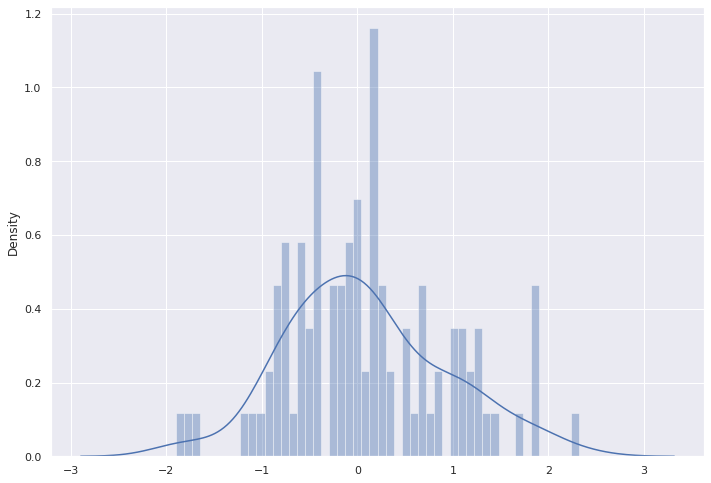

In [24]:
sns.distplot((y_test_predict),bins=50)

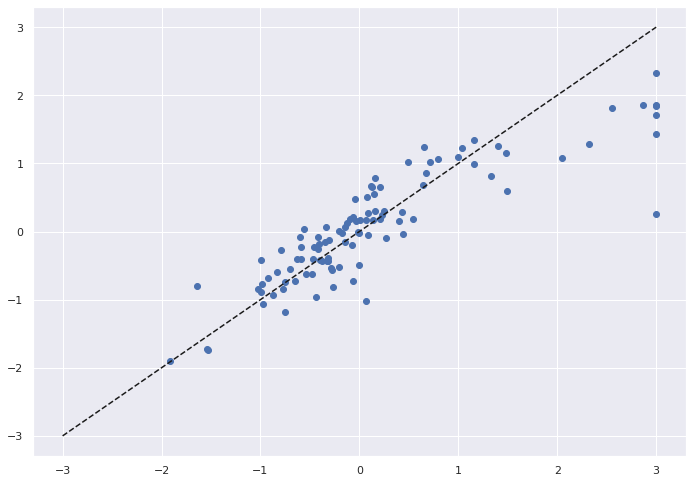

In [25]:
# plotting the y_test vs y_pred
# ideally should have been a straight line
plt.scatter(y_test, y_test_predict)
plt.plot([-3, 3], [-3, 3], '--k')
plt.show()

# Ridge Regression

In [57]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver = "cholesky")
ridge_reg.fit(X_train,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='cholesky', tol=0.001)

In [58]:
y_train_predict = ridge_reg.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = ridge_reg.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
RMSE is 0.5090485371302192
R2 score is 0.727395471131273


The model performance for testing set
RMSE is 0.53439846461036
R2 score is 0.755075477452082


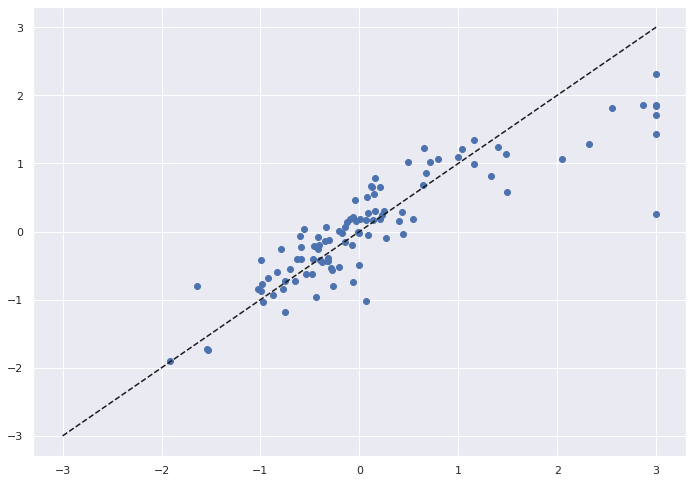

In [59]:
# plotting the y_test vs y_pred
# ideally should have been a straight line
plt.scatter(y_test, y_test_predict)
plt.plot([-3, 3], [-3, 3], '--k')
plt.show()

In [42]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

steps = [
         ('poly', PolynomialFeatures(degree = 2)),
         ('model', Ridge (alpha = 3.8, fit_intercept=True))
]

ridge_pipe=Pipeline(steps)
ridge_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('model',
                 Ridge(alpha=3.8, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [43]:
y_pred_ridge_train = ridge_pipe.predict(X_train)
r2_score_ridge_train = r2_score(y_train, y_pred_ridge_train)
print(r2_score_ridge_train)

y_pred_ridge_test = ridge_pipe.predict(X_test)
r2_score_ridge_test = r2_score(y_test, y_pred_ridge_test)
print(r2_score_ridge_test)

0.9136931338147545
0.9227123338353795


In [60]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X_train,y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [61]:
y_train_predict = lasso_reg.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lasso_reg.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
RMSE is 0.5711213790257533
R2 score is 0.6568598677171822


The model performance for testing set
RMSE is 0.6386803337744117
R2 score is 0.6501604111775661


In [63]:
def plot_learning_curves(model,X,y):
  X_train,X_val, y_train,y_val = train_test_split(X,y,test_size=0.2)
  train_errors,val_errors = [],[]
  for m in range (1,len(X_train)):
    model.fit(X_train[:m],y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
    val_errors.append(mean_squared_error(y_val,y_val_predict))
  plt.plot(np.sqrt(train_errors),"r-+",linewidth=2,label="train")
  plt.plot(np.sqrt(val_errors),"b-",linewidth=3,label="val")

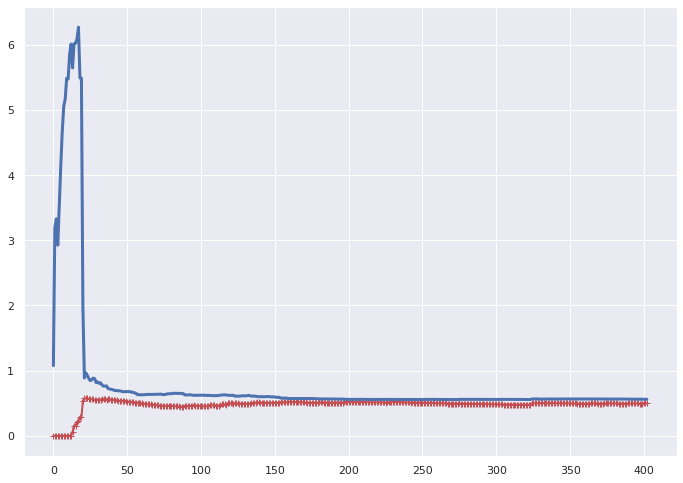

In [64]:
plot_learning_curves(lin_model,X,y)

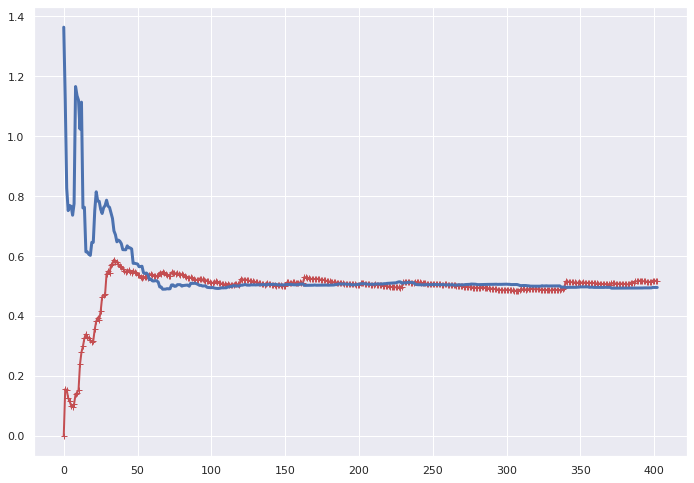

In [65]:
plot_learning_curves(ridge_reg,X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


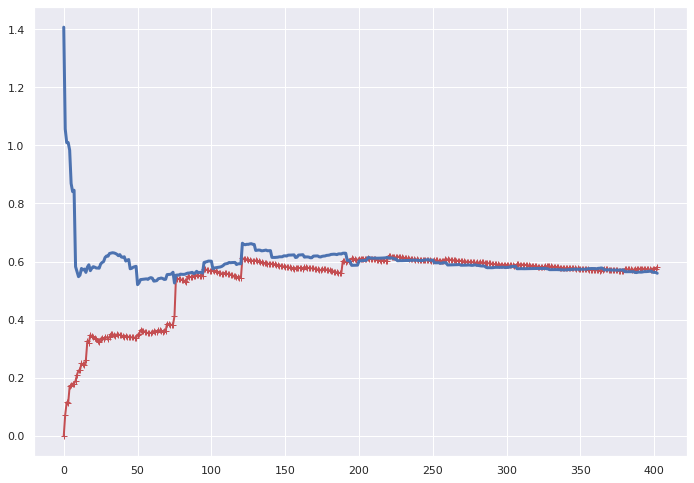

In [66]:
plot_learning_curves(lasso_reg,X,y)

# K-fold

In [32]:
# specify the k-fold cross-validation design for MV
from sklearn.model_selection import KFold

# ten-fold cross-validation employed here
N_FOLDS = 10

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(model_df)))

In [ ]:
boston['log_mv'] = np.log(boston['mv'])
boston.head()